# Growth Stock Indicator

Please fill out:
* Student name: Joe Wilkinson
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## OSEMN
Obtain - Scrub - Explore - Model - Interpret

We used the OSEMN framework to evaluate our stock market data with the intent of building a model to classify stock prices as growth, contract, or neutral based on where the stock will be one year out. 

## Table of Contents

### [1. Obtain](#1)
1. [Project Discovery](#1.1)
2. [Library and Data Import](#1.2)

### [2. Scrub and Explore](#2)
1. [Subsample](#2.1)
2. [Dealing with Data Types](#2.2)
3. [Dealing with Null Values](#2.3)
4. [Check for Multicollinearity](#2.4)
5. [Normalize Data](#2.5)
6. [Creating visualizations](#2.6)

### [4. Model](#4)
1. [One - Hot - Encoding](#4.1)
2. [Regression](#4.2)
3. [Dimensionality Reduction](#4.3)
4. [Final Model](#4.4)


### [5. Interpret](#5) 

<a id="1"></a>
## Obtain

<a id="1.1"></a>
### New York Stock Exchange data from S&P 500
The dataset we are using to build our model is from Dominik Gawlik and was posted on [Kaggle](https://www.kaggle.com/dgawlik/nyse) with a CCO: Public Domain liscense. Prices were fetched from Yahoo Finance, fundamentals are from Nasdaq Financials, extended by some fields from EDGAR SEC databases. The data is split up into multiple CSV files.

1. **prices.csv:** Raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.

2. **prices-split-adjusted.csv:** Same as prices, but there have been added adjustments for splits.

3. **securities.csv:** General description of each company with division on sectors

4. **fundamentals.csv:** Metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.

<a id="1.2"></a>
### Importing Libraries and Data

In [2]:
#imports and loading in data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.style.use('ggplot')

The fundamentals CSV is where we'll get most of our predictors from. This file contains data from the financial filings of each company. Filed once a year, so each row will join with 365 days of stock prices.

In [175]:
fundamentals = pd.read_csv('fundamentals.csv', index_col=0)
fundamentals.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [176]:
fundamentals.drop(['Add\'l income/expense items', 'After Tax ROE', 'Capital Expenditures', 'Capital Surplus', 
                   'Cash Ratio', 'Changes in Inventories', 'Common Stocks', 'Cost of Revenue', 'Current Ratio',
                   'Deferred Asset Charges', 'Deferred Liability Charges', 'Depreciation', 
                   'Earnings Before Interest and Tax', 'Earnings Before Tax', 'Effect of Exchange Rate', 
                   'Equity Earnings/Loss Unconsolidated Subsidiary', 'Goodwill', 'Gross Margin',
                   'Gross Profit', 'Income Tax', 'Intangible Assets', 'Interest Expense', 'Minority Interest', 
                   'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow', 'Net Cash Flow-Operating', 
                   'Net Cash Flows-Financing', 'Net Cash Flows-Investing',
                   'Net Income Adjustments', 'Net Income Applicable to Common Shareholders', 
                   'Net Income-Cont. Operations', 'Net Receivables', 'Non-Recurring Items', 'Operating Margin', 
                   'Other Assets', 'Other Equity', 'Other Financing Activities', 'Other Investing Activities', 
                   'Other Liabilities', 'Other Operating Activities', 'Other Operating Items', 'Pre-Tax Margin', 
                   'Pre-Tax ROE', 'Profit Margin', 'Quick Ratio', 'Retained Earnings',
                   'Sale and Purchase of Stock', 'Sales, General and Admin.', 'Treasury Stock', 'For Year',
                   'Estimated Shares Outstanding'],
                  axis = 1, inplace = True)
fundamentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781 entries, 0 to 1780
Data columns (total 26 columns):
Ticker Symbol                                          1781 non-null object
Period Ending                                          1781 non-null object
Accounts Payable                                       1781 non-null float64
Accounts Receivable                                    1781 non-null float64
Cash and Cash Equivalents                              1781 non-null float64
Fixed Assets                                           1781 non-null float64
Inventory                                              1781 non-null float64
Investments                                            1781 non-null float64
Liabilities                                            1781 non-null float64
Long-Term Debt                                         1781 non-null float64
Long-Term Investments                                  1781 non-null float64
Net Income                                      

For stock prices, we'll use the adjusted for split prices so that stock splits won't affect the outcomes of our classification.

In [177]:
adj_price = pd.read_csv('prices-split-adjusted.csv')
adj_price.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace = True)
adj_price.head()
# adj_price.info()

,date,symbol,close
0,2016-01-05,WLTW,125.839996
1,2016-01-06,WLTW,119.980003
2,2016-01-07,WLTW,114.949997
3,2016-01-08,WLTW,116.620003
4,2016-01-11,WLTW,114.970001


In [178]:
securities = pd.read_csv('securities.csv')
securities.drop(['Security', 'SEC filings', 'GICS Sub Industry', 'Address of Headquarters', 
                 'Date first added', 'CIK'], axis = 1, inplace = True)
securities.head()

,Ticker symbol,GICS Sector
0,MMM,Industrials
1,ABT,Health Care
2,ABBV,Health Care
3,ACN,Information Technology
4,ATVI,Information Technology


Now that we have all the data, we have to combine it into one dataframe. Before we do that, we drop all the columns that we won't use.
- fundamentals: [Unnamed: 0]
- price: [open, low, high]
- Securities: [SEC filings, Date first added, CIK]

Then we'll add the `securities` details to each of the observations in `adj_price`, merging on the `stock symbol`. From there we can add columns for year to both our new master df and fundamentals. This will allow us to to merge the fundamental details to all price observations in that year. 

After we have one combined dataframe, we need to add a column for `pct_growth` that tells us how much the stock has grown or contracted one year from the date.

In [179]:
df = adj_price.merge(securities, how='left', left_on='symbol', right_on='Ticker symbol')
df.drop(['Ticker symbol'], axis=1, inplace=True)

# Make date columns datetime
df['date'] = pd.to_datetime(df['date'])
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'])

# Create a new column for year
df['year'] = [d.year for d in df['date']]
df['month'] = [d.month for d in df['date']]
df['day'] = [d.day for d in df['date']]
# Plus one because we want to use 2012's EOY financials with 2013's prices
fundamentals['year'] = [pe.year + 1 for pe in fundamentals['Period Ending']]

# Merge on year
df = df.merge(fundamentals, how='inner', left_on=['symbol', 'year'], right_on=['Ticker Symbol', 'year'])
df.drop(['Ticker Symbol', 'Period Ending'], axis=1, inplace=True)


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388642 entries, 0 to 388641
Data columns (total 31 columns):
date                                                   388642 non-null datetime64[ns]
symbol                                                 388642 non-null object
close                                                  388642 non-null float64
GICS Sector                                            388642 non-null object
year                                                   388642 non-null int64
month                                                  388642 non-null int64
day                                                    388642 non-null int64
Accounts Payable                                       388642 non-null float64
Accounts Receivable                                    388642 non-null float64
Cash and Cash Equivalents                              388642 non-null float64
Fixed Assets                                           388642 non-null float64
Inventory            

In [181]:
def get_future_price(row):
    date = row.date + relativedelta(years=1)
    price = None
    symbol = row.symbol
    cnt = 0
    while price == None and cnt < 7:
        try:
            price = float(df.loc[(df['date'] == date) & (df['symbol'] == symbol)].close)
            continue
        except:
            price = None
        date = date + relativedelta(days=1)
        cnt +=1
    return price



Our end of year financials are most relevant in the first month of the following year. The further into the next year that we get, the more the company has changed and the more outdated that information is. So, we'll just take the data from January of each year and drop any 2016 observations all together because they can't have a future date in our dataset.

In [182]:
# Get january future close price
# data = df.loc[df['month'] == 1]

# data['future_close'] = data.apply(lambda row: get_future_price(row), axis=1) #36 minutes to execute

# Get full dataset future close price
df['future_close'] = df.apply(lambda row: get_future_price(row), axis=1) # Estimated 6 hrs to execute

data.future_close.isna().sum()

AttributeError: 'DataFrame' object has no attribute 'future_close'

In [183]:
df.future_close.isna().sum()

115313

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31041 entries, 0 to 388408
Data columns (total 32 columns):
date                                                   31041 non-null datetime64[ns]
symbol                                                 31041 non-null object
close                                                  31041 non-null float64
GICS Sector                                            31041 non-null object
year                                                   31041 non-null int64
month                                                  31041 non-null int64
day                                                    31041 non-null int64
Accounts Payable                                       31041 non-null float64
Accounts Receivable                                    31041 non-null float64
Cash and Cash Equivalents                              31041 non-null float64
Fixed Assets                                           31041 non-null float64
Inventory                        

In [184]:
# Save dataset to csv so we don't have to rerun the last bit of code
# data.to_csv('january_data.csv')
df.to_csv('full_data.csv')
# data.drop(['Unnamed: 0'], axis=1, inplace=True)

--- Checkpoint ---

<a id="2"></a>
## Scrub
<a id="2.1"></a>
### 1. Subsample
We took a subsample of the data to imporove run times and stored it in the variable 'df'. 

*To see the final results, comment out.*

In [132]:
# df = pd.read_csv('january_data.csv', index_col=0)
df = pd.read_csv('full_data.csv', index_col=0)
# df = df.sample(frac=0.2, random_state=5)


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388642 entries, 0 to 388641
Data columns (total 32 columns):
date                                                   388642 non-null object
symbol                                                 388642 non-null object
close                                                  388642 non-null float64
GICS Sector                                            388642 non-null object
year                                                   388642 non-null int64
month                                                  388642 non-null int64
day                                                    388642 non-null int64
Accounts Payable                                       388642 non-null float64
Accounts Receivable                                    388642 non-null float64
Cash and Cash Equivalents                              388642 non-null float64
Fixed Assets                                           388642 non-null float64
Inventory                    

<a id="2.2"></a>
### 2. Dealing with Datatypes 
When looking at the data we can see there are only two categorical data columns. We'll need to make sure that we are only adding variables that will add a lot of value without needlessly growing complexity.

- `GICS Sector`: There aren't too many different sectors, so we'll keep thiss column and convert to categorical data type
- `Symbol`: We'll drop this column as they are arbitrary stock names



In [134]:
df['GICS Sector'] = df['GICS Sector'].astype('category')
# df.drop(['symbol'], axis = 1, inplace = True)

In [135]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = [d.year for d in df['date']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388642 entries, 0 to 388641
Data columns (total 32 columns):
date                                                   388642 non-null object
symbol                                                 388642 non-null object
close                                                  388642 non-null float64
GICS Sector                                            388642 non-null category
year                                                   388642 non-null int64
month                                                  388642 non-null int64
day                                                    388642 non-null int64
Accounts Payable                                       388642 non-null float64
Accounts Receivable                                    388642 non-null float64
Cash and Cash Equivalents                              388642 non-null float64
Fixed Assets                                           388642 non-null float64
Inventory                  

<a id="2.3"></a>
### 3. Dealing with Null Values
We'll drop the `Cash Ratio`, `Current Ratio`, and `Quick Ratio` columns because the information here is just a calculation based on other columns, so there's no new information.

We chose to drop all rows that had null values in the `For Year`, `Earnings Per Share`, `Estimated Shares Outstanding`, `future_close` columns. There was a low number of rows that were missing data.

In [136]:

print(df.year.unique()) # outputs: [2016 2013 2014 2015]
print(len(df)) # 31041 entries

df = df.loc[df['year'] != 2016]
print(df.year.unique()) # outputs: [2013 2014 2015]
print(len(df)) #  22606 entries



[2016 2013 2014 2015]
388642
[2013 2014 2015]
276755


In [137]:
# Drop null values
df.dropna(inplace=True)

In [138]:
# Additionally, we'll drop year and day as they should have no effect on the outcome
df.drop(['day'], axis=1, inplace=True)
# data.info()

** Maybe **
Next we'll group each stocks observations by month and year and averaging the price and future_price. This will help us eliminate some of the volitility from any individual day's data.

The next step is to calculate our dependent variable by calculating the percentage change from the current price to the future price.

In [139]:
def growth_category(row):
    p1 = row.close
    p2 = row.future_close
    result = (p2 - p1)/(p1)
    if result >= .1:
        return 2
    elif result >= 0:
        return 1
    else:
        return 0

In [140]:
df['growth_category'] = df.apply(lambda row: growth_category(row), axis=1)

In [141]:
print(len(df.growth_category))
df.growth_category.value_counts()

258676


2    120131
0     89125
1     49420
Name: growth_category, dtype: int64

At this point we can drop the `future_close` column since we were only using it to calculate the growth_category, as well as `symbol` and `date`.

In [142]:
df.head()

,date,symbol,close,GICS Sector,year,month,Accounts Payable,Accounts Receivable,Cash and Cash Equivalents,Fixed Assets,...,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Earnings Per Share,future_close,growth_category
251,2013-01-02,AAL,13.98,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,25.360001,2
252,2013-01-03,AAL,13.66,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,26.540001,2
253,2013-01-04,AAL,14.73,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,27.030001,2
254,2013-01-07,AAL,14.84,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,26.910000,2
255,2013-01-08,AAL,15.16,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,27.629999,2


### 4. One Hot Encoding

We'll have to one hot encode our data early because we're about to use a Groupby function and that operation will delete `GICS Sector` from our featureset.

In [143]:
# Create one-hot-encoded data for categorical columns
df['GICS Sector'] = pd.Categorical(df['GICS Sector'])
sector = pd.get_dummies(df['GICS Sector'], prefix='sector')
df.drop(['GICS Sector'], axis=1, inplace=True)
column_names = df.columns

# Concat standardized columns with one-hot-encoded columns
df = pd.concat([df, sector], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258676 entries, 251 to 276693
Data columns (total 42 columns):
date                                                   258676 non-null object
symbol                                                 258676 non-null object
close                                                  258676 non-null float64
year                                                   258676 non-null int64
month                                                  258676 non-null int64
Accounts Payable                                       258676 non-null float64
Accounts Receivable                                    258676 non-null float64
Cash and Cash Equivalents                              258676 non-null float64
Fixed Assets                                           258676 non-null float64
Inventory                                              258676 non-null float64
Investments                                            258676 non-null float64
Liabilities             

In [144]:
df.drop(['future_close'], axis=1, inplace=True)
df.index = df.date
df = df.groupby(by=[df.symbol, df.month, df.year], as_index=False).mean()
# data.drop(['symbol', 'date'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12344 entries, 0 to 12343
Data columns (total 40 columns):
symbol                                                 12344 non-null object
month                                                  12344 non-null int64
year                                                   12344 non-null int64
close                                                  12344 non-null float64
Accounts Payable                                       12344 non-null float64
Accounts Receivable                                    12344 non-null float64
Cash and Cash Equivalents                              12344 non-null float64
Fixed Assets                                           12344 non-null float64
Inventory                                              12344 non-null float64
Investments                                            12344 non-null float64
Liabilities                                            12344 non-null float64
Long-Term Debt                        

We want our model to be agnostic of the year since we're not doing time series analysis of our data. This means we can drop the year. We'll also drop close because we're only trying to predict percentage growth based on financial statements.

In [145]:
df.drop(['close', 'year', 'symbol'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12344 entries, 0 to 12343
Data columns (total 37 columns):
month                                                  12344 non-null int64
Accounts Payable                                       12344 non-null float64
Accounts Receivable                                    12344 non-null float64
Cash and Cash Equivalents                              12344 non-null float64
Fixed Assets                                           12344 non-null float64
Inventory                                              12344 non-null float64
Investments                                            12344 non-null float64
Liabilities                                            12344 non-null float64
Long-Term Debt                                         12344 non-null float64
Long-Term Investments                                  12344 non-null float64
Net Income                                             12344 non-null float64
Operating Income                   

In [146]:
# df.to_csv('average_by_month_january.csv')
df.to_csv('average_by_month.csv')

--- Checkpoint ---

In [286]:
# df = pd.read_csv('average_by_month_january.csv', index_col=0)
df = pd.read_csv('average_by_month.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12344 entries, 0 to 12343
Data columns (total 37 columns):
month                                                  12344 non-null int64
Accounts Payable                                       12344 non-null float64
Accounts Receivable                                    12344 non-null float64
Cash and Cash Equivalents                              12344 non-null float64
Fixed Assets                                           12344 non-null float64
Inventory                                              12344 non-null float64
Investments                                            12344 non-null float64
Liabilities                                            12344 non-null float64
Long-Term Debt                                         12344 non-null float64
Long-Term Investments                                  12344 non-null float64
Net Income                                             12344 non-null float64
Operating Income                   

In [287]:
# Get our independent and dependent variables
y = df['growth_category'].astype('int')
X = df.drop(['growth_category'], axis = 1)

<a id="2.5"></a>
### 5. Normalize Data
Our next step it to standardize all the data. We don't want certain features to have too strong of an influence just because the nature of that particular feature, the numbers are higher. For example, Earnings per share is generally a low number because it's Revenue divided by the number of shares outstanding, while Our total Assets number is going to be astronomical compared to EPS. We don't want Assets to simply out rank EPS. EPS could potentially be more important, so by standardizing all features, we can even the playing field.

** We will want to exclude the one hot encoded columns from this process **

In [288]:
# Split categorical data from numeric
numeric = X.iloc[:, 0:-11]
categorical = X.iloc[:, -11:]

In [289]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric)

In [290]:
# Put them back together
numeric = pd.DataFrame(numeric_scaled, columns=numeric.columns)
categorical = pd.DataFrame(categorical)
X = pd.concat([numeric, categorical], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12344 entries, 0 to 12343
Data columns (total 36 columns):
month                                                  12344 non-null float64
Accounts Payable                                       12344 non-null float64
Accounts Receivable                                    12344 non-null float64
Cash and Cash Equivalents                              12344 non-null float64
Fixed Assets                                           12344 non-null float64
Inventory                                              12344 non-null float64
Investments                                            12344 non-null float64
Liabilities                                            12344 non-null float64
Long-Term Debt                                         12344 non-null float64
Long-Term Investments                                  12344 non-null float64
Net Income                                             12344 non-null float64
Operating Income                 

### Dimensionality Reduction

[3.87848720e-01 2.04739093e-01 6.53274686e-02 4.63282946e-02
 4.26997371e-02 3.86232776e-02 3.49942813e-02 3.41398372e-02
 2.81851112e-02 2.45944015e-02 1.68252177e-02 1.00887085e-02
 8.90655395e-03 7.44170047e-03 5.77721064e-03 5.42716935e-03
 4.44647560e-03 4.41990695e-03 3.87784546e-03 3.67728292e-03
 2.98726981e-03 2.82474350e-03 2.69170859e-03 2.48005922e-03
 2.35186900e-03 2.07949779e-03 1.70922664e-03 1.35460318e-03
 1.14247986e-03 1.11415579e-03 4.60075959e-04 3.59779660e-04
 7.62026424e-05 3.46902808e-08 7.64896732e-32 8.99217915e-33]


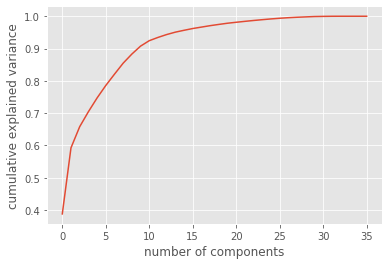

In [291]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
X_reduced = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

14 Features look best

In [292]:
total_var = 0
cnt = 1
for i in pca.explained_variance_ratio_:
    total_var += i
    print(cnt, ': ', total_var, '\t\t', i)
    cnt += 1

1 :  0.38784872032409573 		 0.38784872032409573
2 :  0.5925878130007608 		 0.20473909267666504
3 :  0.6579152816378491 		 0.06532746863708833
4 :  0.7042435762429969 		 0.04632829460514792
5 :  0.7469433132946831 		 0.04269973705168621
6 :  0.7855665908684937 		 0.03862327757381055
7 :  0.8205608721955671 		 0.034994281327073336
8 :  0.8547007093983588 		 0.03413983720279177
9 :  0.8828858206149474 		 0.028185111216588475
10 :  0.9074802221142406 		 0.024594401499293258
11 :  0.9243054397906632 		 0.01682521767642251
12 :  0.9343941483168948 		 0.010088708526231642
13 :  0.9433007022646016 		 0.008906553947706836
14 :  0.950742402736972 		 0.007441700472370377
15 :  0.9565196133803479 		 0.00577721064337584
16 :  0.9619467827325447 		 0.005427169352196894
17 :  0.966393258331244 		 0.004446475598699257
18 :  0.9708131652790075 		 0.004419906947763528
19 :  0.9746910107373707 		 0.003877845458363184
20 :  0.9783682936552424 		 0.0036772829178716208
21 :  0.9813555634630604 		 0.00298726

In [293]:
pca = PCA(n_components = 14)
X_reduced = pca.fit_transform(X)

print(sum(pca.explained_variance_ratio_))

0.9507422583988812


Even though we reduced our features to 14 which is roughly half what we started with, we are still able to explain 95% of all variation in the data. 

<a id="4"></a>
## 4. Model
Our first step is to split our data into two sets, training data and testing data. We'll use a test size of 25% of of our total data. 

From here, we can train different types of classifiers to see which ones produce the most predictive models. Once we have determined which type of classifier is best, we'll us reduce dimensionality and tune the parameters to increase the accuracy of our model.

In [294]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.25, random_state = 3)

### K Neighbors Classifier
The K Neighbors Classifier takes the n closest data points and uses those to 'vote' for which outcome the current point should be classified. Whichever class has the most 'votes'from the n neighbors, wins. In this case we are using the 5 nearest neighbors (the number has to be odd and not divisible by 3 to guarantee one wins out).

In [295]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [296]:
y_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[996 155 163]
 [278 240 179]
 [329 214 532]]
Accuracy:  0.5729099157485418


With an accuracy of 0.57, our model is better than random chance (0.33) but not nearly as high as we would like.

### Support Vector Machine
> A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

[citation](https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72)

In [297]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', random_state = 3)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=3,
    shrinking=True, tol=0.001, verbose=False)

In [298]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[1314    0    0]
 [ 697    0    0]
 [1075    0    0]]
Accuracy:  0.42579390797148414


Using a linear kernel, we had low expectations as our data is much more complex and we have a multi-class problem. The accuracy result reflects this. 

### Kernel SVM

Using the radial basis function kernel, we'll hope to improve the results.

In [299]:
clf = SVC(kernel = 'rbf', random_state = 3)
clf.fit(X_train, y_train)

/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=3,
    shrinking=True, tol=0.001, verbose=False)

In [300]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[915   7 392]
 [369  28 300]
 [432  22 621]]
Accuracy:  0.5068049254698639


The results did imporove from 0.425 to 0.5. Still not nearly as predictive as we would like.

### Decision Tree

> Decision tree builds classification or regression models in the form of a tree structure. It breaks down a data set into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches. Leaf node represents a classification or decision. The topmost decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data.

[citation](https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248)

In [301]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 3)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=3, splitter='best')

In [302]:
y_pred = clf_dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[1121  174   19]
 [ 132  386  179]
 [  21  191  863]]
Accuracy:  0.7679844458846403


Our Decision Tree classifier was a major imporovement from all of our other models. With an accuracy of 0.766, we can say it's a major upgrade from random chance as it's has more than twice the accuracy.

### Random Forest

> Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean prediction of the individual trees.

[citation](https://en.wikipedia.org/wiki/Random_forest)

In [303]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 3)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [304]:
y_pred = clf_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[1164  138   12]
 [ 159  377  161]
 [  17  200  858]]
Accuracy:  0.7773817239144524


Random Forest was an improvement over Decision Tree, which is to be expected as it's built on Decision Tree foundational ideas but adds more certainty to it.

### Validation
Here are the accuracy results from our initial models. 

| Model         | Accuracy |
|---------------|----------|
| K Neighbors   | 0.5625   |
| SVM           | 0.4310   |
| Kernel SVM    | 0.4864   |
| Decision Tree | 0.7424   |
| Random Forest | 0.7745   |

There are two models that are clearly better than the rest, Decision Tree and Random Forest. Next we'll use K-Fold Cross Validation to get a more reliable picture of which model is stronger by eliminating the chance that random sampling caused the difference in outcomes.

Decision Tree Results:
Accuracies Mean:  0.7406593185560453
Accuracies Standard Deviation:  0.013347994981160665
Random Forest Results:
Accuracies Mean:  0.7509148897354144
Accuracies Standard Deviation:  0.010451472682214573


Text(0, 0.5, 'Accuracy Score')

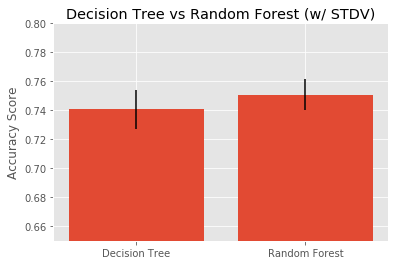

In [305]:
from sklearn.model_selection import cross_val_score

accuracies_dt = cross_val_score(clf_dt, X = X_train, y = y_train, cv = 10)
print('Decision Tree Results:')
print('Accuracies Mean: ', accuracies_dt.mean())
print('Accuracies Standard Deviation: ', accuracies_dt.std())

accuracies_rf = cross_val_score(clf_rf, X = X_train, y = y_train, cv = 10)
print('Random Forest Results:')
print('Accuracies Mean: ', accuracies_rf.mean())
print('Accuracies Standard Deviation: ', accuracies_rf.std())

plt.bar(['Decision Tree', 'Random Forest'],[accuracies_dt.mean(), accuracies_rf.mean()],
        yerr=[accuracies_dt.std(), accuracies_rf.std()])
plt.ylim(0.65, 0.8)
plt.title('Decision Tree vs Random Forest (w/ STDV)')
plt.ylabel('Accuracy Score')

There seems to be minimal difference between the two models, so we move forward with both of them to see which one we can get to be the most predictive.

Our next steps are to imporove our results is hyperparameter tuning. This will help us narrow in on the specific parameters of each model to find the set that best fits our data.

## Hyperparameter Tuning

In [311]:
from sklearn.model_selection import GridSearchCV

dt_clf = DecisionTreeClassifier()

dt_param_grid = {
    "criterion": ['gini', 'entropy'],
    'max_depth': [7, 10, 20],
    'min_samples_split': [1., 2, 10, 20]
}

gs_dt = GridSearchCV(dt_clf, dt_param_grid)
gs_dt.fit(X_train, y_train)

gs_dt.best_params_

/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}

In [316]:
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=2, random_state=3)
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.7430330524951393


In [315]:
rf_clf = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [10, 100, 250],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 10, 20]
}

gs_rf = GridSearchCV(rf_clf, rf_param_grid)
gs_rf.fit(X_train, y_train)

gs_rf.best_params_

/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2,
 'n_estimators': 100}

In [317]:
clf_rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', 
                                max_depth=None, min_samples_split=2, random_state = 3)
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[1149  155   10]
 [ 149  374  174]
 [  11  180  884]]
Accuracy:  0.7799740764744005


Random Forest is better.

Next is XG boost

In [333]:
from xgboost import XGBClassifier

xgb_param_grid = {
    'objective': ['multi:softmax'],
    'num_class': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 20]
}

clf_xgb = XGBClassifier()
gs_xgb = GridSearchCV(clf_xgb, xgb_param_grid)
gs_xgb.fit(X_train, y_train)
gs_xgb.best_params_

/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'gamma': 0.5,
 'max_depth': 20,
 'min_child_weight': 1,
 'num_class': 3,
 'objective': 'multi:softmax',
 'subsample': 1.0}

In [ ]:
gs_xgb.fit(X_train, y_train)
clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

<a id="4.4"></a>
### 4. Final Model

<a id="5"></a>
## Interpretation



### Key Point 1
 

### Key Point 2


### Key Point 3


### Other Notable Observations


# Conclusion



# Future Work

1. Expand the time covered
To make the results more reliable, we need to expand the timeframe of the data in this project. Currently, we only have a short period of time accounted for and none of it was in a bear market. 

2. Adjust our definitions
Currently we are only calculating if the price of the stock increased, decreased or stayed the same. We should adjust our definitions to be in relation to the overal performance of the S&P 500. There are plenty of low cost ETF's and mutual funds that follow the S&P 500. So, for our model to be actionable, we need to make sure that the stocks we are recommending as growth companies will outperform easier, less risky options.

3. Broaden our focus
We can expand the reach of our project by including stocks taht aren't in the S&P 500. Potentially finding a lot more high growth companies. 

---

# Recap
## Scrub

### Dealing with Datatypes
- Waterfront and zipcode were cast to categorical variables
- Sqft_basement, view and yr_renovated were cast to ints
- Turned date into a numermerical column so that we can run statistics on it.

### Dealing with Null Values
- Chose to drop all rows that had null values in the view and sqft_basement columns
- For yr_renovated, we replaced all null and 0 values with the year that the house was built. 

### Check for Multicolinearity

**Columns with high correlation:**
- sqft_living, sqft_above and grade
- bathrooms, sqft_living\*
- sqft_lot and sqft_lot15
- yr_built and year_renovated

**DROPPED:**
- id
- grade
- sqft_living
- sqft_lot15
- yr_renovated

### Normalized Data

- Log transformed certain independent variables and the dependent variable
- Standardized numerical columns to reduce the influence of units or scale

## Model

### Dimensionality Reduction
- Used K-Fold Cross Validation using several values for k to insure no overfitting. 
- Calculated the r squared scores and standard deviation of the r squared scores for each trial. 
- Determined that the results were consistent no matter how the data was divided into train/test sets. 
- Determined 79 features was the most perdictive model with the least variance

### Final Model
- Using 79 features, we built an OLS regression model for Price





Since the r-squared doesn't change, we know removing the columns with a low p-value doesn't effect our model